In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


# Data Prepping and Split

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

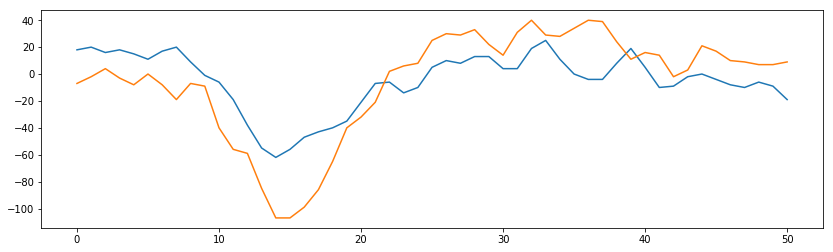

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [131]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [132]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [171]:
train_lim = int(0.85*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (27902, 51)
Test Datasize: (4924, 51)


# Helper Functions

In [162]:
def find_scaled_mse(original, recons, params=None):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    if params is not None:
        print(params, np.median(mse))
    mse = np.array(mse)
    return mse, np.median(mse)

In [163]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [242]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs, filename, figsize = (7,5), ylabel=""):
    fig = plt.figure(1, figsize=figsize)
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.xlabel('LSTM Autoencoder Models', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

In [165]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        #print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder, corrs

In [138]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [166]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])
    
    min_batch = 3
    
    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data.view(-1, min_batch, 1))
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [231]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size, min_batch):
    losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for i, feats in enumerate(selected):
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x.view(-1, min_batch, 1))
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        if num_epoch%200 == 0:
            print('epoch [{}/{}], loss:{:.3f}, running avg:{:.3f}'.format(num_epoch, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple LSTM1 - LIN

In [232]:
class lstm_autoencoder3(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder3, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        hid = 2
        
        first_lin_size = hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hid, num_layers=1)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, 25)
        self.lin3 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.lin2(enc)
        out = self.activation_layer(out)
        dec = self.lin3(out)
        return enc, dec
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [233]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.00001
min_batch = 1

# embedding_size = 4

# ae_14 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_12 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12 = train_ae(ae_12, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
# np.save('models/lstm_models/losses_1_4', np.array(losses_14))
np.save('models/lstm_models/losses_1_2', np.array(losses_12))


# Saving Models
# torch.save(ae_14, 'models/lstm_models/ae_1_4.pt') #Saving the autoencoder model
#torch.save(ae_12, 'models/lstm_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 1647
epoch [0/5000], loss:2008.844, running avg:2008.844
epoch [200/5000], loss:573.098, running avg:345.028
epoch [400/5000], loss:305.752, running avg:313.290
epoch [600/5000], loss:291.248, running avg:383.140
epoch [800/5000], loss:239.741, running avg:301.994
epoch [1000/5000], loss:250.100, running avg:223.384
epoch [1200/5000], loss:104.750, running avg:228.443
epoch [1400/5000], loss:774.074, running avg:272.277
epoch [1600/5000], loss:199.770, running avg:126.601
epoch [1800/5000], loss:89.161, running avg:159.212
epoch [2000/5000], loss:79.403, running avg:213.530
epoch [2200/5000], loss:151.237, running avg:161.166
epoch [2400/5000], loss:224.358, running avg:164.933
epoch [2600/5000], loss:149.492, running avg:95.685
epoch [2800/5000], loss:82.117, running avg:180.448
epoch [3000/5000], loss:153.975, running avg:126.563
epoch [3200/5000], loss:373.388, running avg:178.805
epoch [3400/5000], loss:291.324, running avg:158.555
epoch [3600/5000], los

In [143]:
ae_1 = torch.load('models/lstm_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.9485074914854009
PCA 0.9483949747235512


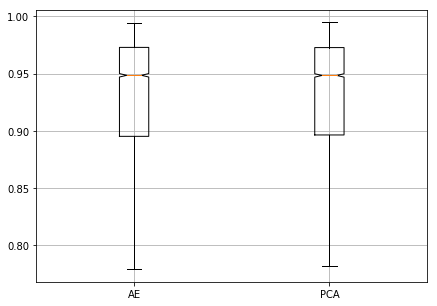

In [148]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.216543984640481
AE 3.285644343276635


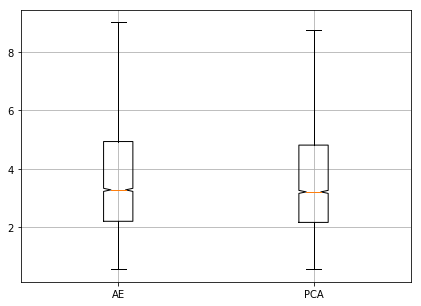

In [150]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# LSTM2- LIN

In [234]:
class lstm_autoencoder4(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder4, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        hid = 2
        
        first_lin_size = hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hid, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, 25)
        self.lin3 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.lin2(enc)
        out = self.activation_layer(out)
        dec = self.lin3(out)
        return enc, dec
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.00001
min_batch = 1

# embedding_size = 4

# ae_14 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_01 = lstm_autoencoder4(length, min_batch, embedding_size).cuda()
ae_01.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_01.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_01 = train_ae(ae_01, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
# np.save('models/lstm_models/losses_1_4', np.array(losses_14))
np.save('models/lstm_models/losses_2_2', np.array(losses_01))


# # Saving Models
# # torch.save(ae_14, 'models/lstm_models/ae_1_4.pt') #Saving the autoencoder model
# torch.save(ae_01, 'models/lstm_models/ae_2_2.pt') #Saving the autoencoder model

# ae_1 = torch.load('models/lstm_models/ae_2_2.pt', map_location=lambda storage, loc: storage)
# #ae_2 = torch.load('models/lstm_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

# _, out_ae = get_network_output(ae_1, 2)
# out_pca = comp_pca(2)
# d = {'AE': out_ae, 'PCA': out_pca}
# find_correlation_coeff(d)

# pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
# ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
# gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

TOTAL PARAMETERS FOR MODEL: 1695
epoch [0/5000], loss:327.556, running avg:327.556
epoch [200/5000], loss:268.559, running avg:317.638
epoch [400/5000], loss:176.739, running avg:368.800
epoch [600/5000], loss:143.658, running avg:212.972
epoch [800/5000], loss:226.883, running avg:187.281
epoch [1000/5000], loss:154.492, running avg:302.096
epoch [1200/5000], loss:368.005, running avg:288.122
epoch [1400/5000], loss:344.827, running avg:222.910
epoch [1600/5000], loss:131.327, running avg:174.392
epoch [1800/5000], loss:217.661, running avg:178.356
epoch [2000/5000], loss:117.991, running avg:173.360
epoch [2200/5000], loss:220.789, running avg:204.875
epoch [2400/5000], loss:145.776, running avg:177.520
epoch [2600/5000], loss:70.205, running avg:130.195
epoch [2800/5000], loss:36.342, running avg:89.878
epoch [3000/5000], loss:76.197, running avg:129.758
epoch [3200/5000], loss:877.631, running avg:169.854
epoch [3400/5000], loss:40.219, running avg:122.932
epoch [3600/5000], loss:5

## Simple LSTM2 - LSTM2

In [235]:
class lstm_autoencoder2(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder2, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        self.hid = 2
        self.batch_size = batch_size
        
        first_lin_size = self.hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hid, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=self.hid, hidden_size=1, num_layers=2)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.activation_layer(enc)
        out = self.lin2(out)
        out = self.activation_layer(out)
        out = self.serialise_input_dec(out)
        out, _ = self.lstm2(out)
        out = self.flatten_input(out)
        dec = self.lin3(out)
        return enc, dec

    
    def serialise_input_dec(self, data):
        data = data.view(-1, self.batch_size, self.hid)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [238]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.0001
min_batch = 1

# embedding_size = 4

# ae_44 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_42 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42 = train_ae(ae_42, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
#np.save('models/lstm_models/losses_4_4', np.array(losses_44))
np.save('models/lstm_models/losses_4_2', np.array(losses_42))


# # Saving Models
# #torch.save(ae_44, 'models/lstm_models/ae_4_4.pt') #Saving the autoencoder model
# torch.save(ae_42, 'models/lstm_models/ae_4_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 3288
epoch [0/5000], loss:881.474, running avg:881.474
epoch [200/5000], loss:240.201, running avg:286.295
epoch [400/5000], loss:81.049, running avg:332.920
epoch [600/5000], loss:153.862, running avg:191.020
epoch [800/5000], loss:58.245, running avg:201.186
epoch [1000/5000], loss:85.805, running avg:108.014
epoch [1200/5000], loss:60.753, running avg:158.790
epoch [1400/5000], loss:111.623, running avg:103.759
epoch [1600/5000], loss:127.912, running avg:164.901
epoch [1800/5000], loss:126.699, running avg:124.101
epoch [2000/5000], loss:137.934, running avg:99.425
epoch [2200/5000], loss:45.855, running avg:96.581
epoch [2400/5000], loss:105.261, running avg:114.433
epoch [2600/5000], loss:94.855, running avg:114.394
epoch [2800/5000], loss:48.044, running avg:107.618
epoch [3000/5000], loss:162.834, running avg:99.063
epoch [3200/5000], loss:176.083, running avg:111.747
epoch [3400/5000], loss:178.420, running avg:101.507
epoch [3600/5000], loss:58.584

In [154]:
ae_1 = torch.load('models/lstm_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.9475924537980092
PCA 0.9483949747235509


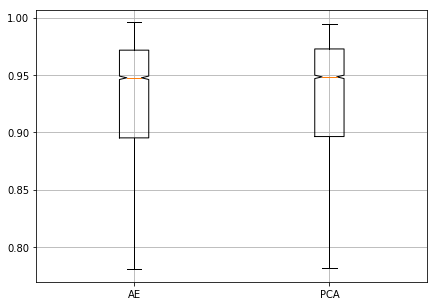

In [155]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2165439846404675
AE 4.56176007666524


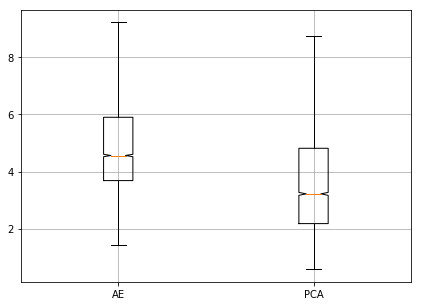

In [156]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# LSTM1 - LSTM1

In [236]:
class lstm_autoencoder0(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder0, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        self.hid = 2
        self.batch_size = batch_size
        
        first_lin_size = self.hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hid, num_layers=1)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=self.hid, hidden_size=1, num_layers=1)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.activation_layer(enc)
        out = self.lin2(out)
        out = self.activation_layer(out)
        out = self.serialise_input_dec(out)
        out, _ = self.lstm2(out)
        out = self.flatten_input(out)
        dec = self.lin3(out)
        return enc, dec

    
    def serialise_input_dec(self, data):
        data = data.view(-1, self.batch_size, self.hid)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.0001
min_batch = 1

# embedding_size = 4

# ae_44 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_02 = lstm_autoencoder0(length, min_batch, embedding_size).cuda()
ae_02.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_02.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_02 = train_ae(ae_02, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
#np.save('models/lstm_models/losses_4_4', np.array(losses_44))
np.save('models/lstm_models/losses_11_2', np.array(losses_02))


# # Saving Models
# #torch.save(ae_44, 'models/lstm_models/ae_4_4.pt') #Saving the autoencoder model
# torch.save(ae_02, 'models/lstm_models/ae_11_2.pt') #Saving the autoencoder model

# ae_1 = torch.load('models/lstm_models/ae_11_2.pt', map_location=lambda storage, loc: storage)
# #ae_2 = torch.load('models/lstm_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

# _, out_ae = get_network_output(ae_1, 2)
# out_pca = comp_pca(2)
# d = {'AE': out_ae, 'PCA': out_pca}
# find_correlation_coeff(d)

# pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
# ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
# gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

TOTAL PARAMETERS FOR MODEL: 3224
epoch [0/5000], loss:666.844, running avg:666.844
epoch [200/5000], loss:93.294, running avg:132.443
epoch [400/5000], loss:189.197, running avg:225.497
epoch [600/5000], loss:115.105, running avg:137.605
epoch [800/5000], loss:96.822, running avg:146.559
epoch [1000/5000], loss:82.220, running avg:156.738
epoch [1200/5000], loss:78.078, running avg:177.469
epoch [1400/5000], loss:137.743, running avg:137.603
epoch [1600/5000], loss:58.798, running avg:243.057
epoch [1800/5000], loss:89.047, running avg:121.982
epoch [2000/5000], loss:50.892, running avg:116.858
epoch [2200/5000], loss:78.685, running avg:103.960
epoch [2400/5000], loss:100.499, running avg:113.404
epoch [2600/5000], loss:131.471, running avg:121.947
epoch [2800/5000], loss:151.865, running avg:132.078
epoch [3000/5000], loss:91.096, running avg:98.341
epoch [3200/5000], loss:63.487, running avg:131.614
epoch [3400/5000], loss:100.958, running avg:134.460
epoch [3600/5000], loss:60.299,

In [ ]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse, 'Baseline': baseline})

In [ ]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [ ]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

In [ ]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

In [ ]:
inputs = electrode_data_test[0, :]
inputs = torch.from_numpy(inputs).float()
batch_size = 3
inputs = inputs.view(-1, batch_size, 1)
print(inputs.shape)

In [243]:
lstm1_lin, lstm2_lin, lstm1_lstm1, lstm2_lstm2 = None, None, None, None

def load_all_models():
    global lstm1_lin, lstm2_lin, lstm1_lstm1, lstm2_lstm2
    lstm1_lin = torch.load('models/lstm_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
    lstm2_lin = torch.load('models/lstm_models/ae_2_2.pt', map_location=lambda storage, loc: storage)
    
    lstm1_lstm1 = torch.load('models/lstm_models/ae_11_2.pt', map_location=lambda storage, loc: storage)
    lstm2_lstm2 = torch.load('models/lstm_models/ae_4_2.pt', map_location=lambda storage, loc: storage)

load_all_models()

def find_cor_and_mse(ae):
    _, out_ae = get_network_output(ae, 2)
    ae_mse, mse_med = find_scaled_mse(electrode_data_test, out_ae)
    a, b = find_correlation_coeff({'AE': out_ae}, plot=False)
    ae_cor_med = a[0][1]
    ae_corrs = np.array(b['AE'])
    return ae_mse, ae_corrs, mse_med, ae_cor_med

In [244]:
out_pca = comp_pca(2)
pca_mse, pca_med = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
a, b = find_correlation_coeff({'PCA': out_pca}, plot=False)
pca_cor_med = a[0][1]
pca_corrs = np.array(b['PCA'])

out_base = comp_pca(0)
base_mse, base_med = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
a, b = find_correlation_coeff({'Baseline': out_base}, plot=False)
base_cor_med = a[0][1]
base_corrs = np.array(b['Baseline'])

PCA 3.2281291754661074
Baseline 10.204287245214399


In [245]:
ae_1_mse, ae_1_cor, ae_1_mse_med, ae_1_cor_med = find_cor_and_mse(lstm1_lin)
ae_2_mse, ae_2_cor, ae_2_mse_med, ae_2_cor_med = find_cor_and_mse(lstm2_lin)
ae_3_mse, ae_3_cor, ae_3_mse_med, ae_3_cor_med = find_cor_and_mse(lstm1_lstm1)
ae_4_mse, ae_4_cor, ae_4_mse_med, ae_4_cor_med = find_cor_and_mse(lstm2_lstm2)

In [246]:
dict_of_mse = {"Asym. LSTM-AE \n(1647)": ae_1_mse, "Asym. LSTM-AE \n(1695)": ae_2_mse, "Sym. LSTM-AE \n(3224)": ae_3_mse, 
               "Sym. LSTM-AE \n(3288)": ae_4_mse, "PCA": pca_mse, "Baseline": base_mse}

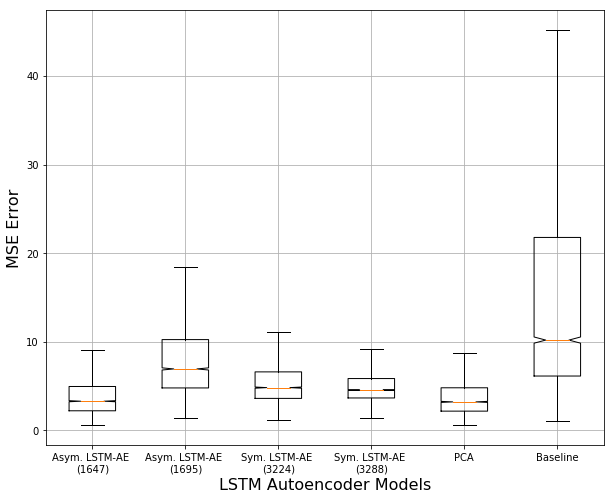

In [247]:
gen_boxplots(dict_of_mse, filename="lstm_mse_box.pdf", figsize=(10, 8), ylabel="MSE Error")

In [180]:
print("Asym. LSTM-AE (1647) & ", ae_1_mse_med, "\nAsym. LSTM-AE (1695) & ", ae_2_mse_med, "\nSym. LSTM-AE (3224) & ", ae_3_mse_med, 
        "\nSym. LSTM-AE (3288) & ", ae_4_mse_med, "\nPCA & ", pca_med, "\nBaseline & ", base_med)

Asym. LSTM-AE (1647) &  3.304504263526246 
Asym. LSTM-AE (1695) &  6.947895053189092 
Sym. LSTM-AE (3224) &  4.839096426796976 
Sym. LSTM-AE (3288) &  4.562990780653751 
PCA &  3.2281291754661545 
Baseline &  10.204287245214399


In [248]:
dict_of_cor = {"Asym. LSTM-AE \n(1647)": ae_1_cor, "Asym. LSTM-AE \n(1695)": ae_2_cor, "Sym. LSTM-AE \n(3224)": ae_3_cor, 
               "Sym. LSTM-AE \n(3288)": ae_4_cor, "PCA": pca_corrs, "Baseline": base_corrs}

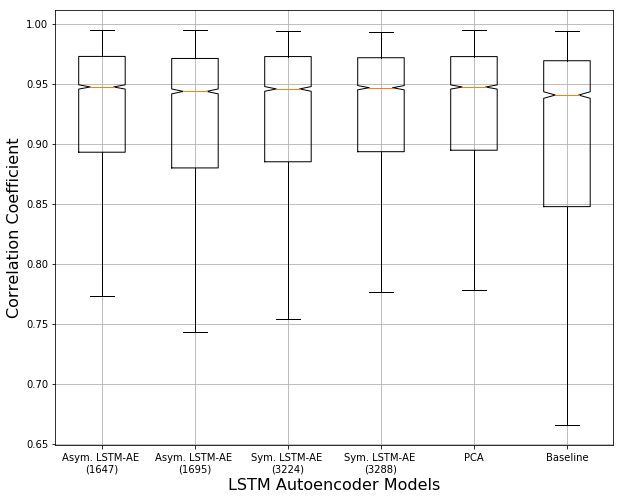

In [249]:
gen_boxplots(dict_of_cor, filename="lstm_correlation_box.pdf", figsize=(10, 8), ylabel="Correlation Coefficient")

In [186]:
print("Asym. LSTM-AE (1647) & ", ae_1_cor_med, "\nAsym. LSTM-AE (1695) & ", ae_2_cor_med, "\nSym. LSTM-AE (3224) & ", ae_3_cor_med, 
        "\nSym. LSTM-AE (3288) & ", ae_4_cor_med, "\nPCA & ", pca_cor_med, "\nBaseline & ", base_cor_med)

Asym. LSTM-AE (1647) &  0.9473583671751311 
Asym. LSTM-AE (1695) &  0.9436348303480253 
Sym. LSTM-AE (3224) &  0.9457131152984435 
Sym. LSTM-AE (3288) &  0.9467275603637035 
PCA &  0.9473133023945349 
Baseline &  0.9406087594335943


In [250]:
def plot_loss(losses, filename):
    fig = plt.figure(figsize=(10, 6))
    #plt.plot(vlosses, label="val")
    plt.plot(losses, label="train")
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.grid()
    plt.legend()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

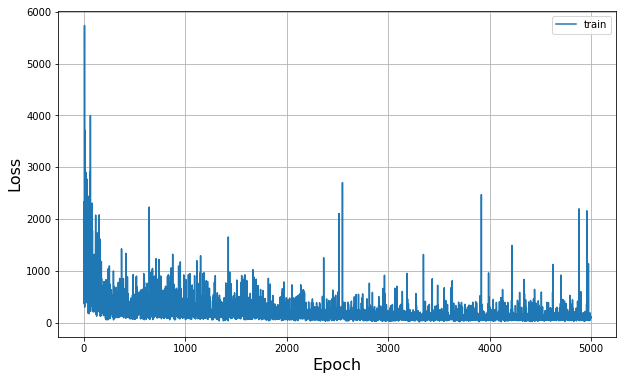

In [251]:
# LSTM1-LIN
#v1 = np.load('models/final_models/vlosses_1_2.npy')
t1 = np.load('models/lstm_models/losses_1_2.npy')
plot_loss(t1, "lstm_lin_1_curve.pdf")

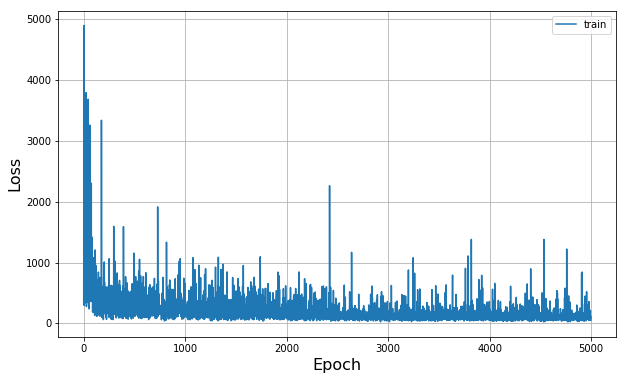

In [252]:
# LSTM2-LIN
#v1 = np.load('models/final_models/vlosses_1_2.npy')
t1 = np.load('models/lstm_models/losses_2_2.npy')
plot_loss(t1, "lstm_lin_2_curve.pdf")

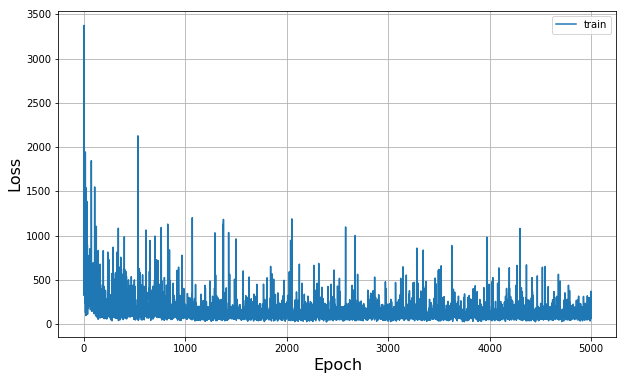

In [253]:
# LSTM1-LSTM1
#v1 = np.load('models/final_models/vlosses_1_2.npy')
t1 = np.load('models/lstm_models/losses_4_2.npy')
plot_loss(t1, "lstm_lstm_1_curve.pdf")

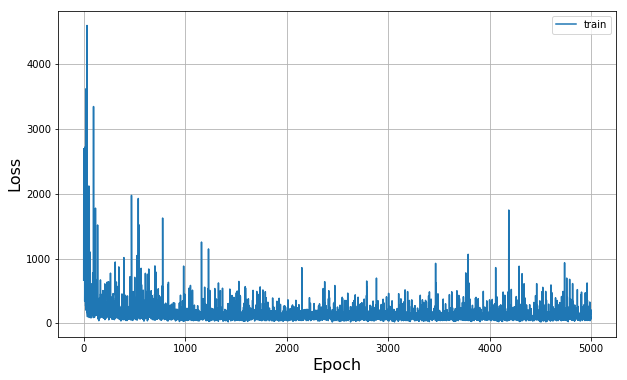

In [254]:
# LSTM2-LSTM2
#v1 = np.load('models/final_models/vlosses_1_2.npy')
t1 = np.load('models/lstm_models/losses_11_2.npy')
plot_loss(t1, "lstm_lstm_2_curve.pdf")

In [204]:
print(t1.shape)

(1500000,)


In [210]:
print(np.median(t1[1000000:]))

110.94153
